<a href="https://colab.research.google.com/github/IvnGenza/Data-Science/blob/main/HeartAttackPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

import scipy.stats as stats
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score

In [ ]:
path = "/content/heart.csv"
df = pd.read_csv(path)

#Rename some features
df.rename(columns={'output':'HeartAttack'},inplace=True)
df.rename(columns={'thalachh':'maxHR'},inplace=True)
df.rename(columns={'trtbps':'bloodP'},inplace=True)

In [ ]:
#Check if we have null values
df.isnull().sum()

In [ ]:
#Check if we have some duplicate rows
df[df.duplicated()]

,age,sex,cp,bloodP,chol,fbs,restecg,maxHR,exng,oldpeak,slp,caa,thall,HeartAttack
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [ ]:
#Remove all duplicate rows
df.drop_duplicates(inplace = True)

In [ ]:
#Continuous features
continuous_labels = ['age','bloodP','chol','maxHR','oldpeak']
con_f = df[continuous_labels]
#con_f.describe()

In [ ]:
#Categorical features
categorical_labels = ['sex','cp','fbs','restecg','exng','slp','caa','thall']
cat_f = df[categorical_labels]
#cat_f.describe()####1

# ***Exploratory Data Analysis***



In [ ]:
df.head()

,age,sex,cp,bloodP,chol,fbs,restecg,maxHR,exng,oldpeak,slp,caa,thall,HeartAttack
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
#Show total number of rows, columns, data types, non/null count
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          302 non-null    int64  
 1   sex          302 non-null    int64  
 2   cp           302 non-null    int64  
 3   bloodP       302 non-null    int64  
 4   chol         302 non-null    int64  
 5   fbs          302 non-null    int64  
 6   restecg      302 non-null    int64  
 7   maxHR        302 non-null    int64  
 8   exng         302 non-null    int64  
 9   oldpeak      302 non-null    float64
 10  slp          302 non-null    int64  
 11  caa          302 non-null    int64  
 12  thall        302 non-null    int64  
 13  HeartAttack  302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 43.5 KB


- This dataset does not contain any missing values!

## **Numeric distribution visualisation**

- ***Boxplots*** for outlier detection

- ***histograms*** for distribution analysis

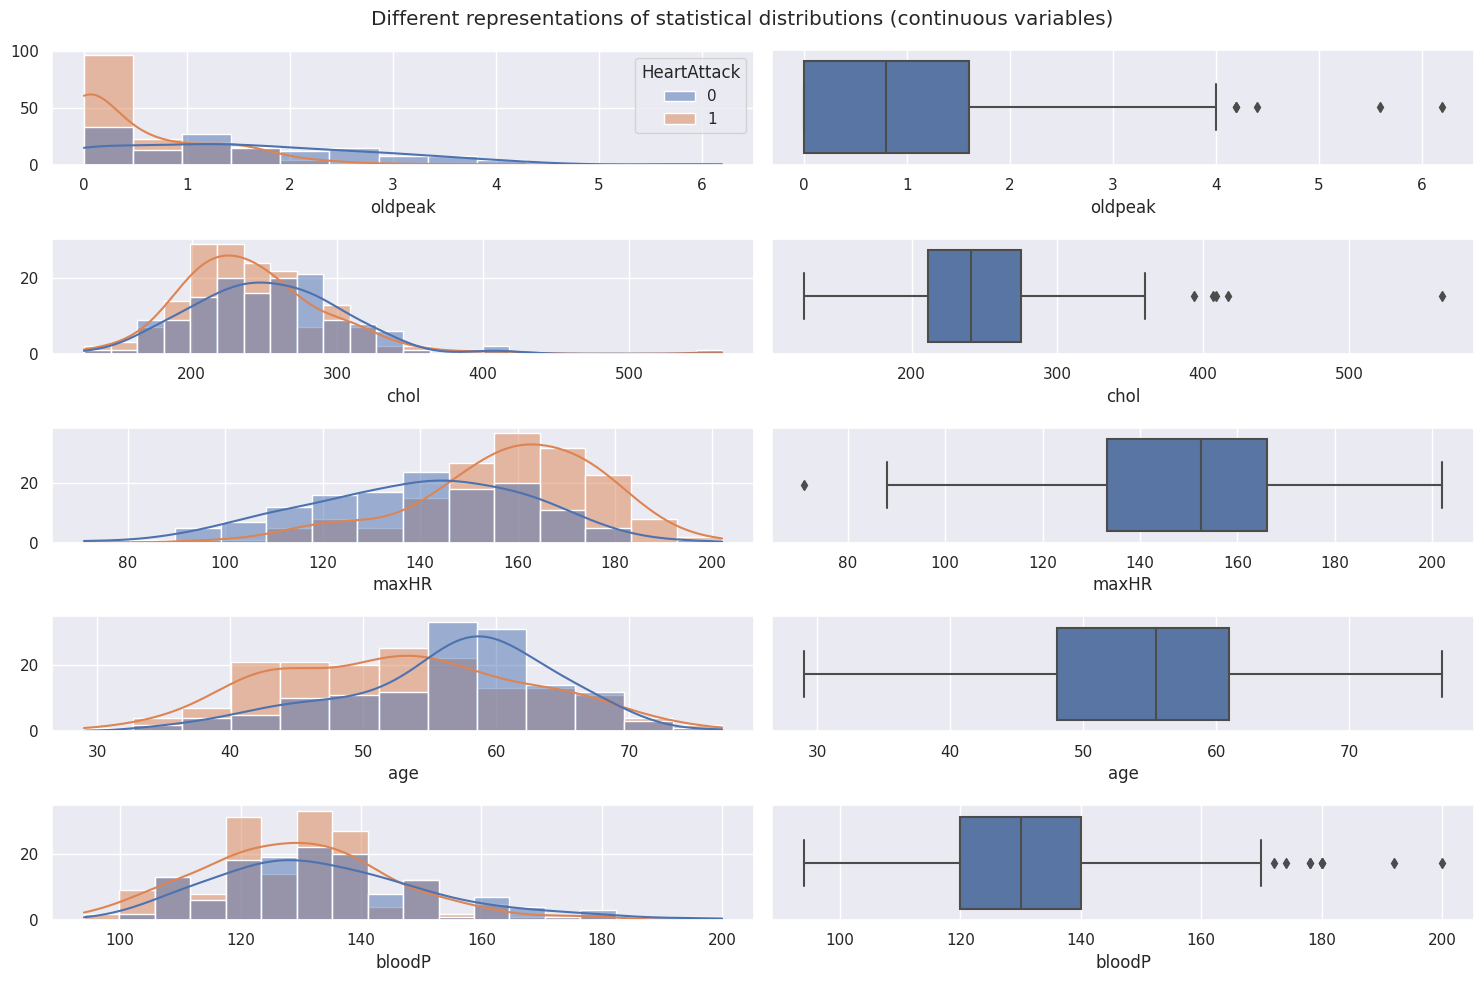

In [ ]:
sns.set_theme()
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,10))

sns.histplot(data=df, x="oldpeak", hue="HeartAttack", ax=axes[0, 0], kde=True)
sns.boxplot(data=df, x="oldpeak", ax=axes[0, 1])

sns.histplot(data=df, x="chol", hue="HeartAttack", ax=axes[1, 0],legend = False,kde=True)
sns.boxplot(data=df, x="chol", ax=axes[1, 1])

sns.histplot(data=df, x="maxHR", hue="HeartAttack", ax=axes[2, 0],legend = False,kde=True)
sns.boxplot(data=df, x="maxHR", ax=axes[2, 1])

sns.histplot(data=df, x="age", hue="HeartAttack", ax=axes[3, 0],legend = False,kde=True)
sns.boxplot(data=df, x="age", ax=axes[3, 1])

sns.histplot(data=df, x="bloodP", hue="HeartAttack", ax=axes[4, 0],legend = False,kde=True)
sns.boxplot(data=df, x="bloodP", ax=axes[4 ,1])

for i in range(0,5):
  axes[i,0].set_ylabel("")

fig.suptitle("Different representations of statistical distributions (continuous variables)")
plt.tight_layout()
plt.show()

- all columns except 'age' have couple of outliers

In [ ]:
#Indexes of rows with outliers
print(df.sort_values('bloodP', ascending=False).head(6).index)
print(df.sort_values('maxHR').head(1).index)
print(df.sort_values('oldpeak', ascending=False).head(4).index)
print(df.sort_values('chol', ascending=False).head(5).index)

Int64Index([223, 248, 266, 203, 110, 260], dtype='int64')
Int64Index([272], dtype='int64')
Int64Index([204, 221, 291, 250], dtype='int64')
Int64Index([85, 28, 246, 220, 96], dtype='int64')


## **Numeric correlation analysis**

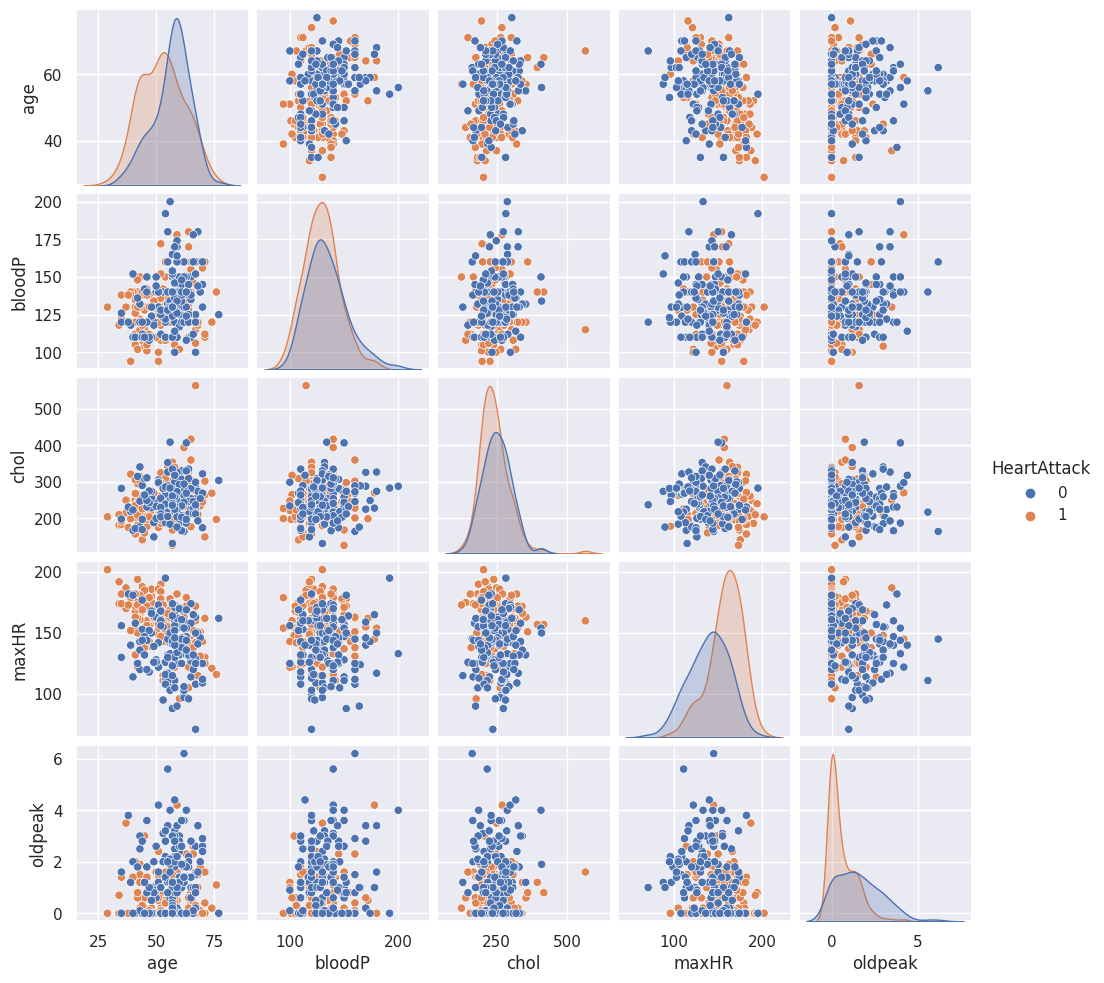

In [ ]:
sns.pairplot(df[['age','bloodP','chol','maxHR','oldpeak',"HeartAttack"]], hue="HeartAttack", height=2)

**Conclusions based on histographs boxplot and pairplot (Continuous features)**



*   All numerical attributes except age have outliers
*   oldpeak has the strongest correlation with the target trait, but at the
     same time has the worst distribution.

*   We think partition a 'oldpeak' into discrete values (discretization/binning) might be a good solution here.

*   To handle outliers, we can use standardization or robust
- pairplot shows us that there is no linear correlation between the numeric features (very weak)

## **Categorical distribution visualisation**

In [ ]:
#Pie charts for categorical features
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'domain'},{'type':'domain'},{'type':'domain'}],[{'type':'domain'},{'type':'domain'},{'type':'domain'}],[{'type':'domain'},{'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['Gender',
                                    'Chest Pain type',
                                    'fasting blood sugar',
                                    'resting electrocardiographic results',
                                    'exercise induced angina',
                                    'Slope of the peak exercise ST',
                                    'num. of major vessels',
                                    'Thallium',
                                    'Heart Attack'])

fig.add_trace(px.pie(cat_f, names='sex').data[0], 1, 1)
fig.add_trace(px.pie(cat_f, names='cp').data[0], 1, 2)
fig.add_trace(px.pie(cat_f, names='fbs').data[0], 1, 3)
fig.add_trace(px.pie(cat_f, names='restecg').data[0], 2, 1)
fig.add_trace(px.pie(cat_f, names='exng').data[0], 2, 2)
fig.add_trace(px.pie(cat_f, names='slp').data[0], 2, 3)
fig.add_trace(px.pie(cat_f, names='caa').data[0], 3, 1)
fig.add_trace(px.pie(cat_f, names='thall').data[0], 3, 2)
fig.add_trace(px.pie(df, names='HeartAttack').data[0], 3, 3)

fig.update_layout(width=1000, height=800,title_text='Pie charts for categorical features',title_font=dict(size=20))
fig.update_traces(textinfo="percent",textposition='inside',showlegend=False)


fig.show()

In [ ]:
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'histogram'},{'type':'histogram'},{'type':'histogram'}],[{'type':'histogram'},{'type':'histogram'},{'type':'histogram'}],[{'type':'histogram'},{'type':'histogram'},{'type':'histogram'}]],
                    subplot_titles=['Heart Attack',
                                    'Chest Pain type',
                                    'fasting blood sugar',
                                    'resting electrocardiographic results',
                                    'exercise induced angina',
                                    'Slope of the peak exercise ST',
                                    'num. of major vessels',
                                    'Thallium',
                                    'Gender'])

fig.add_trace(px.histogram(df,  x="sex", color="HeartAttack").data[1], 3, 3)
fig.add_trace(px.histogram(df,  x="sex", color="HeartAttack").data[0], 3, 3)

fig.add_trace(px.histogram(df, x="cp", color="HeartAttack").data[1], 1, 2)
fig.add_trace(px.histogram(df, x="cp", color="HeartAttack").data[0], 1, 2)

fig.add_trace(px.histogram(df, x="fbs", color="HeartAttack").data[1], 1, 3)
fig.add_trace(px.histogram(df, x="fbs", color="HeartAttack").data[0], 1, 3)

fig.add_trace(px.histogram(df, x="restecg", color="HeartAttack").data[1], 2, 1)
fig.add_trace(px.histogram(df, x="restecg", color="HeartAttack").data[0], 2, 1)

fig.add_trace(px.histogram(df, x="exng", color="HeartAttack").data[1], 2, 2)
fig.add_trace(px.histogram(df, x="exng", color="HeartAttack").data[0], 2, 2)

fig.add_trace(px.histogram(df, x="slp", color="HeartAttack").data[1], 2, 3)
fig.add_trace(px.histogram(df, x="slp", color="HeartAttack").data[0], 2, 3)

fig.add_trace(px.histogram(df, x="caa", color="HeartAttack").data[1], 3, 1)
fig.add_trace(px.histogram(df, x="caa", color="HeartAttack").data[0], 3, 1)

fig.add_trace(px.histogram(df, x="thall", color="HeartAttack").data[1], 3, 2)
fig.add_trace(px.histogram(df, x="thall", color="HeartAttack").data[0], 3, 2)


fig.update_layout(width=1000, height=800,title_text='Histograms for categorical features vs. HeartAttack',title_font=dict(size=20))
fig.update_traces(showlegend=False)


fig.add_shape(type="rect",xref="paper",yref="paper",x0=0.15,y0=0.94,x1=0.14,y1=0.96,fillcolor="red",opacity=0.9)
fig.add_annotation(xref="paper",yref="paper",x=0.1,y=0.97,text="0 -",showarrow=False,font=dict(color="black", size=14))
fig.add_shape(type="rect",xref="paper",yref="paper",x0=0.15,y0=0.90,x1=0.14,y1=0.92,fillcolor="blue",opacity=0.9)
fig.add_annotation(xref="paper",yref="paper",x=0.1,y=0.93,text="1 -",showarrow=False,font=dict(color="black", size=14))

fig.update_layout(bargap=0.2)
fig.show()

***Conclusion ✅***

- thall (thallium stress test) coulmn have 4 categories but we can see in [this](https://healthinfo.healthengine.com.au/dipyridamole-thallium-scan) article that it have only three possible categories. So probably **class 0 is null** and we can try to change it to class 2 with a biggest amount of samples.

- **fbs** have weakest correlation with target feature, We can try to remove this feature.

- **caa** have 5 categories but we can see in [this](https://www.hindawi.com/journals/cmmm/2017/8272091/tab1/) article what number of major vessels can be (0–3), it means class 4 is also **null** and we can move it to class 0.
We also can try to make this feature be binary, which will have 2 classes (1 = have major vessels / 0 = no major vessels)


In [ ]:
df.sort_values(by=['thall'], ascending=False).tail(5)

,age,sex,cp,bloodP,chol,fbs,restecg,maxHR,exng,oldpeak,slp,caa,thall,HeartAttack
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1,0
242,64,1,0,145,212,0,0,132,0,2.0,1,2,1,0
244,56,1,0,132,184,0,0,105,1,2.1,1,1,1,0
247,66,1,1,160,246,0,1,120,1,0.0,1,3,1,0
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1


thall (*thallium stress test*) coulmn have two zero values(it means we have 4 variables in this column).

We can see in [this](https://healthinfo.healthengine.com.au/dipyridamole-thallium-scan) article that *thallium stress test* have only three iterations of the result, so we decided to change these values to 1 = normal.

# **Pre - processing**

## **Data cleaning**

- **removing null classes from 'caa' and 'thall' columns**

In [ ]:
#Changing all '0' values in 'thall' column to value '2'
df['thall']=df['thall'].replace(0, 2)

#Changing all '4' values in 'caa' column to value '0'
df['caa']=df['caa'].replace(4, 0)

In [ ]:
#Check uniqe classes in 'caa' and 'thall' columns
caa_unique_classes = df['caa'].unique()
thall_unique_classes = df['thall'].unique()
print(thall_unique_classes)
print(caa_unique_classes)

[1 2 3]
[0 2 1 3]


- **Making a copy of our dataSet and labels of categorical and continuous features so we can easily manipulate with data and refresh our preprocessing part**

In [ ]:
#Creating copy of our dataset for pre-processing
df_pp = df.copy()

continuous_labels_pp = continuous_labels.copy()
categorical_labels_pp = categorical_labels.copy()

In [ ]:
#Changing data type of categorical featuers
df_pp['caa'] = df_pp['caa'].astype('category')
df_pp['cp'] = df_pp['cp'].astype('category')
df_pp['restecg'] = df_pp['restecg'].astype('category')
df_pp['exng'] = df_pp['exng'].astype('category')
df_pp['slp'] = df_pp['slp'].astype('category')
df_pp['thall'] = df_pp['thall'].astype('category')
df_pp['fbs'] = df_pp['fbs'].astype('category')
df_pp['sex'] = df_pp['sex'].astype('category')

df_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          302 non-null    int64   
 1   sex          302 non-null    category
 2   cp           302 non-null    category
 3   bloodP       302 non-null    int64   
 4   chol         302 non-null    int64   
 5   fbs          302 non-null    category
 6   restecg      302 non-null    category
 7   maxHR        302 non-null    int64   
 8   exng         302 non-null    category
 9   oldpeak      302 non-null    float64 
 10  slp          302 non-null    category
 11  caa          302 non-null    category
 12  thall        302 non-null    category
 13  HeartAttack  302 non-null    int64   
dtypes: category(8), float64(1), int64(5)
memory usage: 28.1 KB


## **Feature celection**

In [ ]:
#create a correlation matrix from the data
matrix = df.corr()
#create a mask fo the matrix
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

<Axes: >

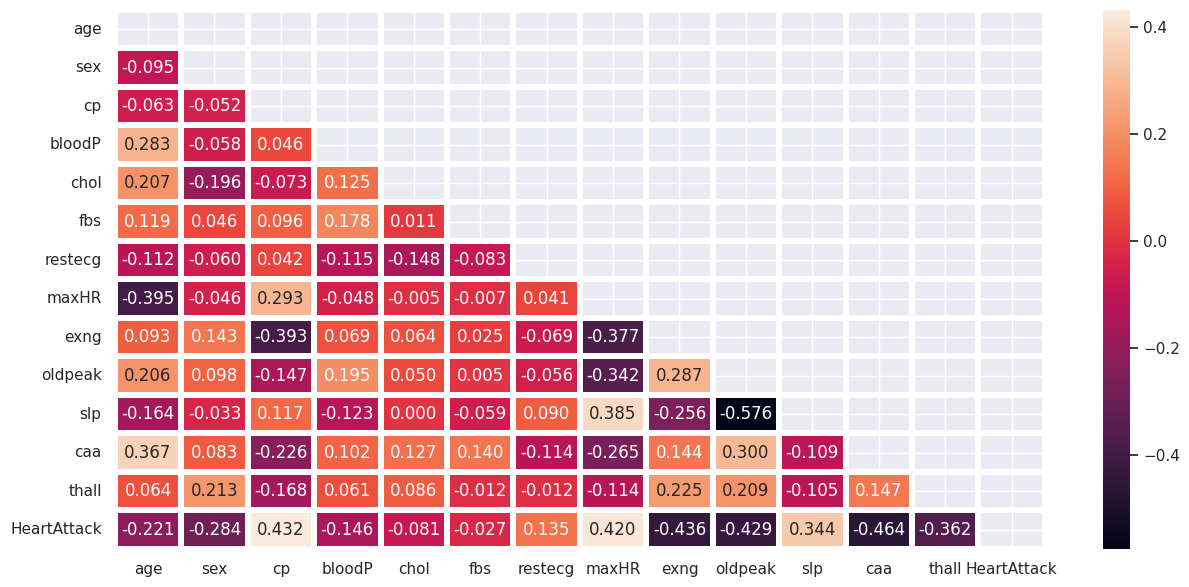

In [ ]:
#visualisation for our matrix
plt.figure(figsize =(15,7))
sns.heatmap(df.corr(),mask = mask, linewidths=3,annot = True,fmt='.3f')


'slope' and 'oldpeak' have strong negative correlation

HeartAttack and Chest Pain type have strong positive correlation

- ***Chi-square test***

In [ ]:
from scipy.stats import chi2_contingency

#Chi-square test to check the correlation between each categorical feature and the target feature
for label in categorical_labels_pp:
  cross_tab = pd.crosstab(df_pp[label], df_pp['HeartAttack'])
  chi2_stat, p_value, _, _ = chi2_contingency(cross_tab)

  print('------------ '+label+' ------------')
  print(f"Chi square stat is: {chi2_stat:.2f}")
  print(f"P value is:{p_value}\n")

------------ sex ------------
Chi square stat is: 23.08
P value is:1.5508552054949547e-06

------------ cp ------------
Chi square stat is: 80.98
P value is:1.8926838351935918e-17

------------ fbs ------------
Chi square stat is: 0.09
P value is:0.7611374700928197

------------ restecg ------------
Chi square stat is: 9.73
P value is:0.007713053269318974

------------ exng ------------
Chi square stat is: 55.46
P value is:9.556466486179178e-14

------------ slp ------------
Chi square stat is: 46.89
P value is:6.577782760917924e-11

------------ caa ------------
Chi square stat is: 73.69
P value is:6.919066104481066e-16

------------ thall ------------
Chi square stat is: 83.98
P value is:5.8135009856856e-19



***results***


All of our variables have a statistically significant relationship with the target feature because their p-values are very low and Chi stat actually high.
This indicates the importance of these variables in predicting or explaining the target trait.


We still can try to remove 'sex' 'fbs' 'restecg' (got a weakeset correlation with target column)


We also can check correlation between categorical features for potential multicollinearity.


<Axes: >

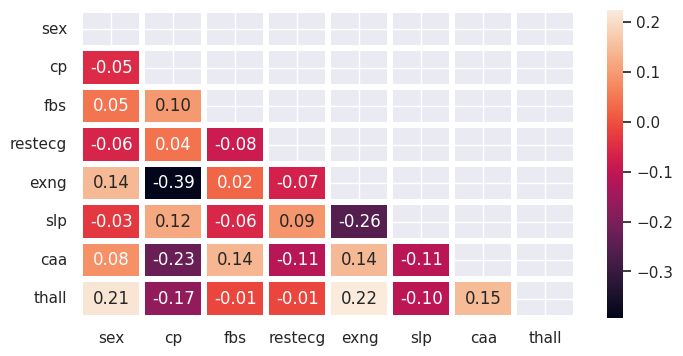

In [ ]:
#Create heatmap for categorical features

matrix = df_pp[categorical_labels_pp].corr(numeric_only=False)
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize =(8,4))
sns.heatmap(df_pp[categorical_labels_pp].corr(numeric_only=False),mask = mask, linewidths=3,annot = True, fmt='.2f')

**Check feature importances by Random Forest**

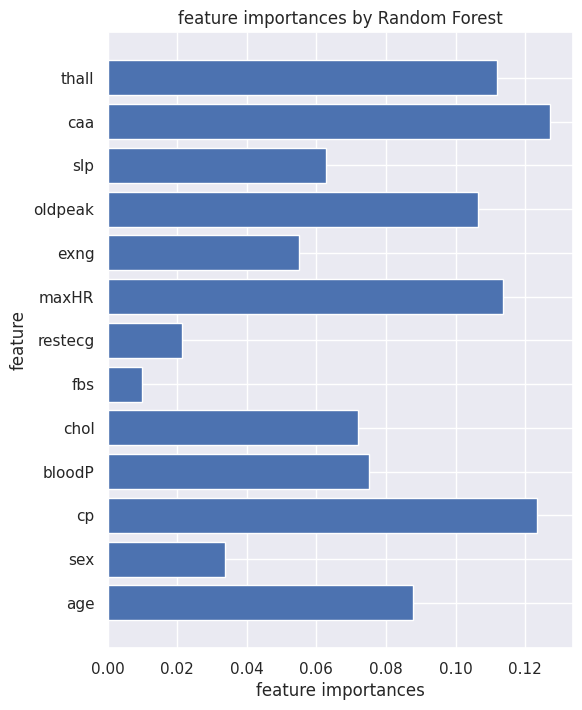

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_pp.drop('HeartAttack', axis = 1)
y = df_pp['HeartAttack']

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_

plt.figure(figsize=(6, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), X.columns)
plt.xlabel('feature importances')
plt.ylabel('feature')
plt.title('feature importances by Random Forest')
plt.show()

***Conclusions✅***
- **maxHR**, **oldpeak**, **cp** and **caa** are the most important features.
- **sex**, **fbs** and **restecg** most insignificant features.

In [ ]:
# Remove 'fbs' feature from dataFrame
####1
del df_pp['fbs']
categorical_labels_pp.remove('fbs')

In [ ]:
##Remove 'sex' feature from dataFrame

# del df_pp['sex']
# categorical_labels_pp.remove('sex')

In [ ]:
##Remove 'restecg' feature from dataFrame

# del df_pp['restecg']
# categorical_labels_pp.remove('restecg')

## **Handling categorical features**

In [ ]:
#Creating a new boolean column for each class in 'caa' feature (one-hot encoding).

df_pp['caa_0'] = (df_pp['caa'] == 0).astype(int)
categorical_labels_pp.append('caa_0')
df_pp['caa_1'] = (df_pp['caa'] == 1).astype(int)
categorical_labels_pp.append('caa_1')
df_pp['caa_2'] = (df_pp['caa'] == 2).astype(int)
categorical_labels_pp.append('caa_2')
df_pp['caa_3'] = (df_pp['caa'] == 3).astype(int)
categorical_labels_pp.append('caa_3')

#del df_pp['caa']
#categorical_labels_pp.remove('caa')


# # #Creating a new boolean column for each class in 'thall' feature (one-hot encoding).
df_pp['thall_1'] = (df_pp['thall'] == 1).astype(int)
categorical_labels_pp.append('thall_1')
df_pp['thall_2'] = (df_pp['thall'] == 2).astype(int)
categorical_labels_pp.append('thall_2')
df_pp['thall_3'] = (df_pp['thall'] == 3).astype(int)
categorical_labels_pp.append('thall_3')

#del df_pp['thall']
#categorical_labels_pp.remove('thall')


# # #Creating a new boolean column for each class in 'slp' feature (one-hot encoding).
df_pp['slp_0'] = (df_pp['slp'] == 0).astype(int)
categorical_labels_pp.append('slp_0')
df_pp['slp_1'] = (df_pp['slp'] == 1).astype(int)
categorical_labels_pp.append('slp_1')
df_pp['slp_2'] = (df_pp['slp'] == 2).astype(int)
categorical_labels_pp.append('slp_2')

#del df_pp['slp']
#categorical_labels_pp.remove('slp')


#Creating a new boolean column for each class in 'cp' feature (one-hot encoding).
# df_pp['cp_0'] = (df_pp['cp'] == 0).astype(int)
# categorical_labels_pp.append('cp_0')
# df_pp['cp_1'] = (df_pp['cp'] == 1).astype(int)
# categorical_labels_pp.append('cp_1')
# df_pp['cp_2'] = (df_pp['cp'] == 2).astype(int)
# categorical_labels_pp.append('cp_2')
# df_pp['cp_3'] = (df_pp['cp'] == 3).astype(int)
# categorical_labels_pp.append('cp_3')

## **Handling numerical features**

*Indexes of the rows with outliers:*


- **'bloodP'** - [223, 248, 266, 203, 110, 260]

- **'maxHR'** - [272]

- **'oldpeak'** - [204, 221, 291, 250]

- **'chol'** - [85, 28, 246, 220, 96]

-----------------------------------------------

Removing outliers

In [ ]:
# df_pp = df_pp.drop([223, 248, 266, 203, 110, 260])   # bloodP
# df_pp = df_pp.drop(272)                       # maxHR
# df_pp = df_pp.drop([204, 221, 291, 250])           # oldpeak
# df_pp = df_pp.drop([85, 28, 246, 220, 96])          # chol

**Numerical features have some outliers and are not well-distributed. Therefore, we gonna try using smoothing techniques and improve performance by reducing the noise and variability in the data.**

Create bins using equal width approach

In [ ]:
def discretize_equal_width(column, n_bins):
  sorted_column = df_pp[column].sort_values()
  bins = pd.cut(sorted_column, n_bins)        # equal width

  return bins

Create bins using equal frequency approach


In [ ]:
def discretize_equal_depth(column, n_bins):
  sorted_column = df_pp[column].sort_values()
  bins = pd.qcut(sorted_column, n_bins)      # equal frequency

  return bins

function that compares the original and smoothed values of a column

In [ ]:
def compare_smoothed_column(Original, Smoothed):

  fig, axs = plt.subplots(1, 2, figsize=(10, 3))

  sns.histplot(df_pp, x=Original, ax=axs[0])
  axs[0].set_title("Original")

  sns.histplot(df_pp, x=Smoothed, ax=axs[1])
  axs[1].set_title("Smoothed")

  plt.tight_layout()
  plt.show()

## Smoothing by **bin boundaries**

In [ ]:
def smoothing_bin_boundaries(label, bins):

  df_pp[label + '_bin_boundary'] = df[label].groupby(bins).transform(lambda x: x.min() if x.name.left == x.min() else x.max())
  compare_smoothed_column(label, label + '_bin_boundary')


  continuous_labels_pp.append(label + '_bin_boundary')

  del df_pp[label]
  continuous_labels_pp.remove(label)

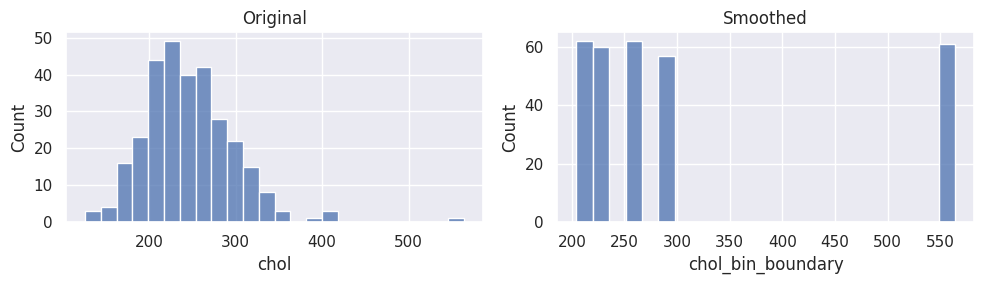

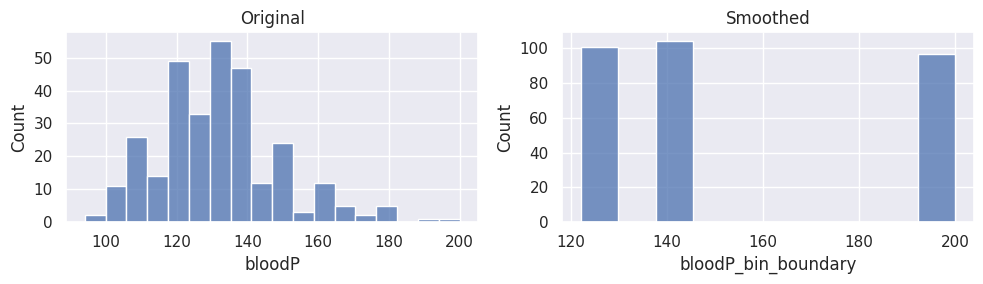

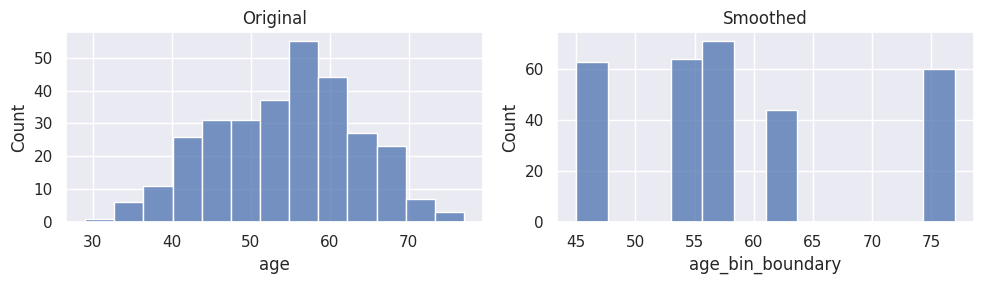

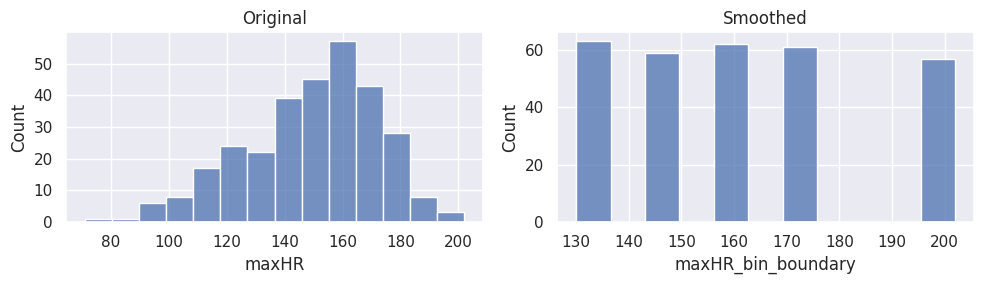

In [ ]:
              ########################
              ### Equal depth bins ###
              ########################

# depth_bins_chol = discretize_equal_depth('chol', 5)  # Or 3 bins      #chol
# smoothing_bin_boundaries('chol', depth_bins_chol)

# depth_bins_bloodP = discretize_equal_depth('bloodP', 3) # Or 4 bins   #bloodP
# smoothing_bin_boundaries('bloodP', depth_bins_bloodP)

# depth_bins_age = discretize_equal_depth('age', 5)    # Or 6 bins       #age
# smoothing_bin_boundaries('age', depth_bins_age)

# depth_bins_maxHR = discretize_equal_depth('maxHR', 5)                 #maxHR
# smoothing_bin_boundaries('maxHR', depth_bins_maxHR)

In [ ]:
              ########################
              ### Equal width bins ###
              ########################


# width_bins_chol = discretize_equal_width('chol', 7)                 #chol
# smoothing_bin_boundaries('chol', width_bins_chol)

# width_bins_bloodP = discretize_equal_width('bloodP', 4)             #bloodP
# smoothing_bin_boundaries('bloodP', width_bins_bloodP)

# width_bins_age = discretize_equal_width('age', 6)                   #age
# smoothing_bin_boundaries('age', width_bins_age)

# width_bins_maxHR = discretize_equal_width('maxHR', 6)               #maxHR
# smoothing_bin_boundaries('maxHR', width_bins_maxHR)

## Smoothing by **bin means**

In [ ]:
def smoothing_bin_means(label, bins):

  df_pp[label+'_bin_mean'] = df_pp[label].groupby(bins).transform('mean')
  compare_smoothed_column(label, label + '_bin_mean')

  continuous_labels_pp.append(label+'_bin_mean')


  del df_pp[label]
  continuous_labels_pp.remove(label)

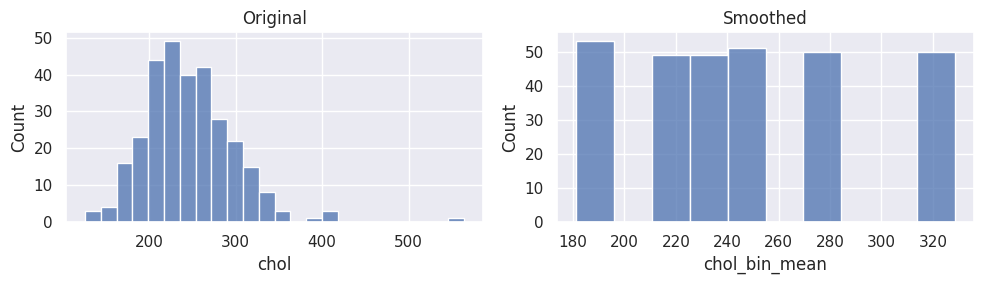

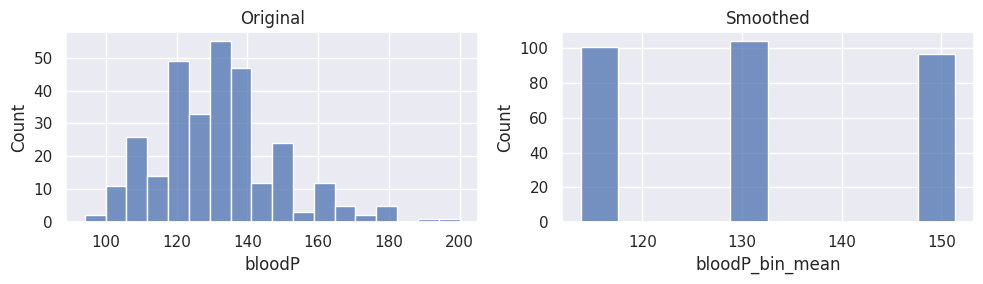

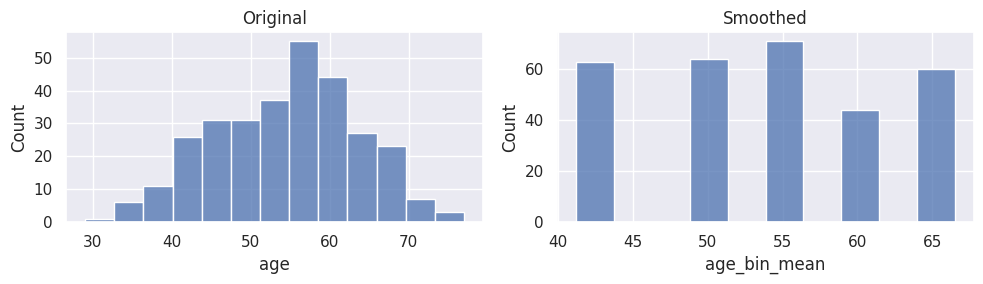

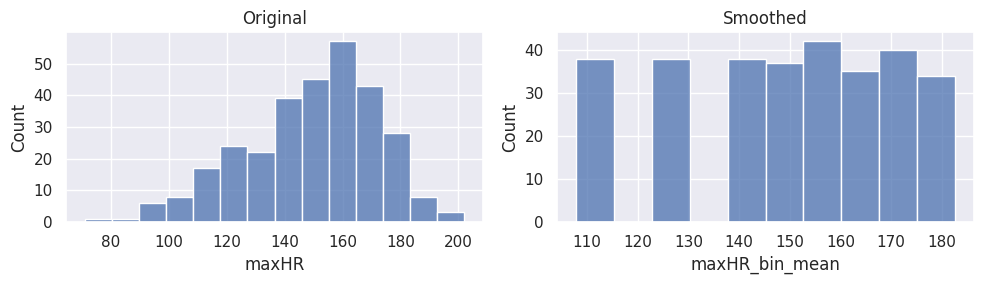

In [ ]:
              ########################
              ### Equal depth bins ###
              ########################


# depth_bins_chol = discretize_equal_depth('chol', 6)  # Or 3 bins
# smoothing_bin_means('chol', depth_bins_chol)

# depth_bins_bloodP = discretize_equal_depth('bloodP', 3) # Or 4 bins
# smoothing_bin_means('bloodP', depth_bins_bloodP)

# depth_bins_age = discretize_equal_depth('age', 5)
# smoothing_bin_means('age', depth_bins_age)

# depth_bins_maxHR = discretize_equal_depth('maxHR', 8)
# smoothing_bin_means('maxHR', depth_bins_maxHR)

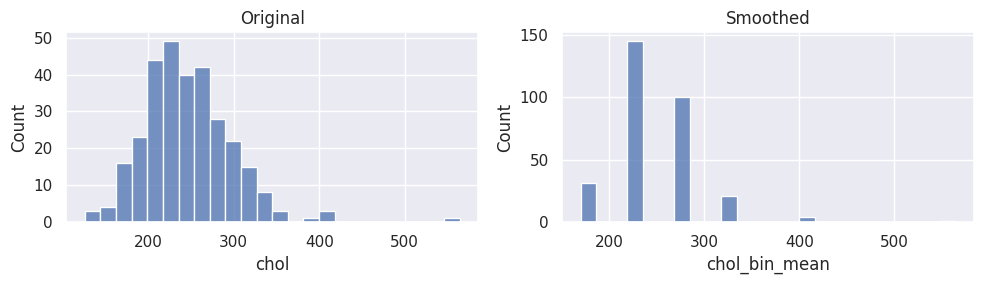

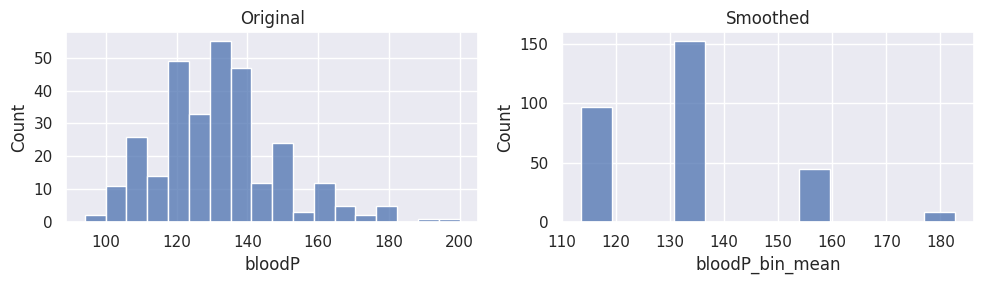

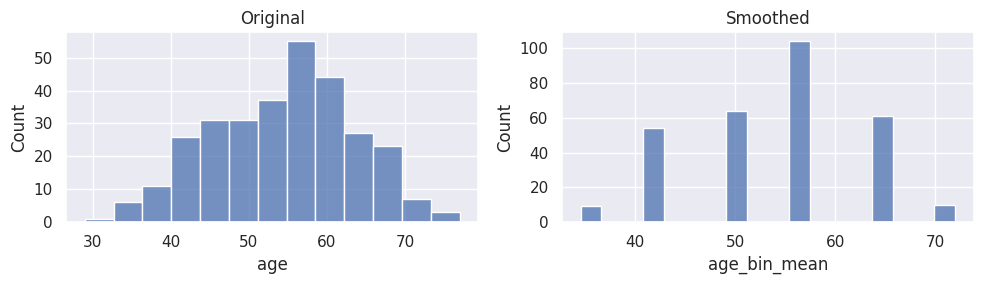

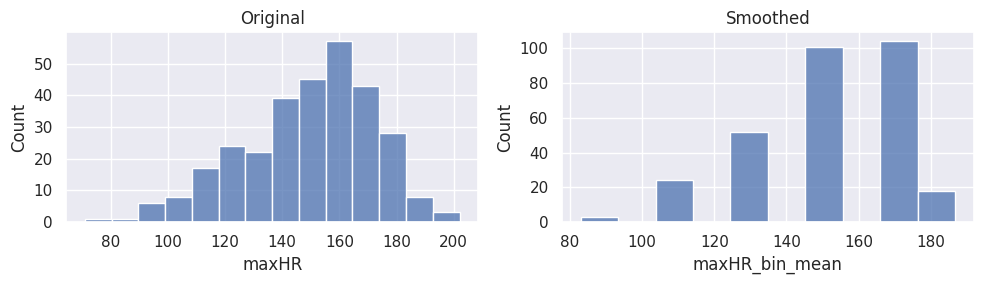

In [ ]:
              ########################
              ### Equal width bins ###
              ########################


width_bins_chol = discretize_equal_width('chol', 7)
smoothing_bin_means('chol', width_bins_chol)

width_bins_bloodP = discretize_equal_width('bloodP', 4)
smoothing_bin_means('bloodP', width_bins_bloodP)

width_bins_age = discretize_equal_width('age', 6)
smoothing_bin_means('age', width_bins_age)

width_bins_maxHR = discretize_equal_width('maxHR', 6)
smoothing_bin_means('maxHR', width_bins_maxHR)

In [ ]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sex              302 non-null    category
 1   cp               302 non-null    category
 2   restecg          302 non-null    category
 3   exng             302 non-null    category
 4   oldpeak          302 non-null    float64 
 5   slp              302 non-null    category
 6   caa              302 non-null    category
 7   thall            302 non-null    category
 8   HeartAttack      302 non-null    int64   
 9   caa_0            302 non-null    int64   
 10  caa_1            302 non-null    int64   
 11  caa_2            302 non-null    int64   
 12  caa_3            302 non-null    int64   
 13  thall_1          302 non-null    int64   
 14  thall_2          302 non-null    int64   
 15  thall_3          302 non-null    int64   
 16  slp_0            302 non-null    int64   
 1

## **Split dataset to train and test datasets**

In [ ]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sex              302 non-null    category
 1   cp               302 non-null    category
 2   restecg          302 non-null    category
 3   exng             302 non-null    category
 4   oldpeak          302 non-null    float64 
 5   slp              302 non-null    category
 6   caa              302 non-null    category
 7   thall            302 non-null    category
 8   HeartAttack      302 non-null    int64   
 9   caa_0            302 non-null    int64   
 10  caa_1            302 non-null    int64   
 11  caa_2            302 non-null    int64   
 12  caa_3            302 non-null    int64   
 13  thall_1          302 non-null    int64   
 14  thall_2          302 non-null    int64   
 15  thall_3          302 non-null    int64   
 16  slp_0            302 non-null    int64   
 1

In [ ]:
y = df_pp['HeartAttack']
X = df_pp[categorical_labels_pp + continuous_labels_pp]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [ ]:
X

,sex,cp,restecg,exng,slp,caa,thall,caa_0,caa_1,caa_2,...,thall_2,thall_3,slp_0,slp_1,slp_2,oldpeak,chol_bin_mean,bloodP_bin_mean,age_bin_mean,maxHR_bin_mean
0,1,3,0,0,0,0,1,1,0,0,...,0,0,1,0,0,2.3,222.165517,133.315789,64.803279,148.336634
1,1,2,1,0,0,0,2,1,0,0,...,1,0,1,0,0,3.5,222.165517,133.315789,34.555556,186.722222
2,0,1,0,0,2,0,2,1,0,0,...,1,0,0,0,1,1.4,222.165517,133.315789,42.333333,167.961538
3,1,1,1,0,2,0,2,1,0,0,...,1,0,0,0,1,0.8,222.165517,113.463918,57.355769,167.961538
4,0,0,1,1,2,0,2,1,0,0,...,1,0,0,0,1,0.6,331.000000,113.463918,57.355769,167.961538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0,0,1,1,1,0,3,1,0,0,...,0,1,0,1,0,0.2,222.165517,133.315789,57.355769,126.038462
299,1,3,1,0,1,0,3,1,0,0,...,0,1,0,1,0,1.2,278.190000,113.463918,42.333333,126.038462
300,1,0,1,0,1,2,3,0,0,1,...,0,1,0,1,0,3.4,222.165517,133.315789,64.803279,148.336634
301,1,0,1,1,1,1,3,0,1,0,...,0,1,0,1,0,1.2,169.935484,133.315789,57.355769,126.038462


## **Scaling numerical features in train and test sets**

In [ ]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()


#Scaling numerical columns
X_train[continuous_labels_pp] = scaler.fit_transform(X_train[continuous_labels_pp])
X_test[continuous_labels_pp] = scaler.fit_transform(X_test[continuous_labels_pp])

In [ ]:
print('Train data :   ', X_train.shape)
print('Train target : ', y_train.shape)
print('\nTest data :      ', X_test.shape)
print('Test target :    ', y_test.shape)

Train data :    (241, 22)
Train target :  (241,)

Test data :       (61, 22)
Test target :     (61,)


In [ ]:
train_data = pd.concat([X_train, pd.DataFrame({'HeartAttack': y_train})], axis=1)
test_data = pd.concat([X_test, pd.DataFrame({'HeartAttack': y_test})], axis=1)
combined_data = pd.concat([train_data, test_data])

# Saving cleaned data
#combined_data.to_csv('combined_data.csv', index=False)

# ***Models***

Heatmap for confusion matrix visualization:

In [ ]:
#Function for matrix visualisation
def show_matrix(my_df):
  for index, row in my_df.iterrows():
    ConfusionM_visualization(row['matrix'],row['Model'])

In [ ]:
def ConfusionM_visualization(matrix,l):
  plt.figure(figsize=(4, 3))
  Confusion_Matrix_df = pd.DataFrame(matrix)
  sns.heatmap(Confusion_Matrix_df, annot=True, linewidths=1)
  plt.title(l)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")

## ***K-MEANS Cluster (Not a prediction model!)***

In [ ]:
from sklearn.cluster import KMeans

def K_MEANS():

  KM = KMeans(n_clusters=2, n_init=10)
  KM.fit(X_train)



  # test set accuracy
  y_pred = KM.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred)
  # metrics
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  c_matrix = confusion_matrix(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # train set accuracy
  y_pred = KM.predict(X_train)
  accuracy_train = accuracy_score(y_train, y_pred)

## ***Decision Tree***

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree():

  DT = DecisionTreeClassifier(criterion= 'entropy', max_depth = 6, min_samples_split = 10, random_state=40)
  DT.fit(X_train,y_train)



  # test set accuracy
  y_pred = DT.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred)
  # metrics
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  c_matrix = confusion_matrix(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # train set accuracy
  y_pred = DT.predict(X_train)
  accuracy_train = accuracy_score(y_train, y_pred)


  return ['Decision Tree', accuracy_train, accuracy_test, precision, recall, f1, c_matrix]

## ***Naive Bayers***

In [ ]:
from sklearn.naive_bayes import GaussianNB

def Naive_Bayers():

  NB = GaussianNB()
  NB.fit(X_train,y_train)



  # test set accuracy
  y_pred = NB.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred)
  # metrics
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  c_matrix = confusion_matrix(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # train set accuracy
  y_pred = NB.predict(X_train)
  accuracy_train = accuracy_score(y_train, y_pred)


  return ['Naive Bayers', accuracy_train, accuracy_test, precision, recall, f1, c_matrix]

## ***K-Nearest Neighbors (KNN)***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def KNN():


  KNN = KNeighborsClassifier(n_neighbors=11)
  KNN.fit(X_train,y_train)



  # test set accuracy
  y_pred = KNN.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred)
  # metrics
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  c_matrix = confusion_matrix(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # train set accuracy
  y_pred = KNN.predict(X_train)
  accuracy_train = accuracy_score(y_train, y_pred)


  return ['KNN', accuracy_train, accuracy_test, precision, recall, f1, c_matrix]

#**RUN_NO_PP**

Run without preprocessing:

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())

df_RUN_NO_PP_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_NO_PP_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.917,0.820,0.909,0.789,0.845
1,Naive Bayers,0.838,0.738,0.923,0.632,0.750
2,KNN,0.710,0.705,0.778,0.737,0.757


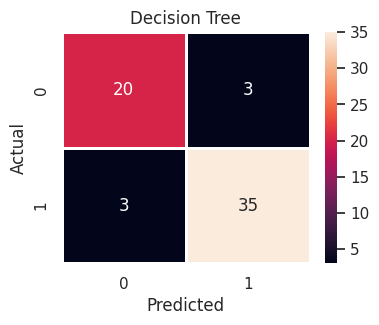

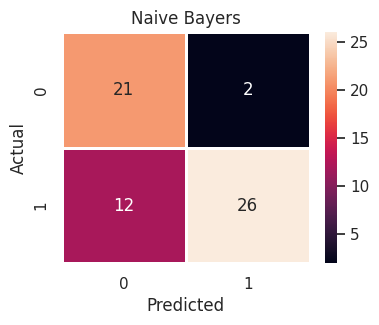

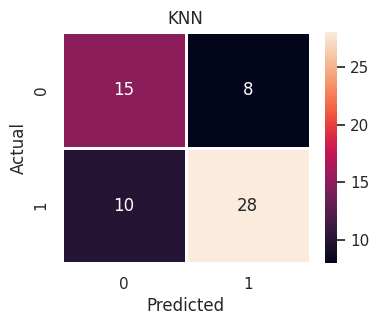

In [ ]:
show_matrix(df_RUN_NO_PP_results)

#**RUN_PP1**

***PP steps:***
- Remove null classes from 'caa' and 'thall'
- Remove 'fbs' (most insignificant feature)
- Normalization by MinMax Scaler


In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP1_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP1_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,1.000,0.820,0.886,0.816,0.849
1,Naive Bayers,0.855,0.770,0.929,0.684,0.788
2,KNN,0.851,0.836,0.912,0.816,0.861


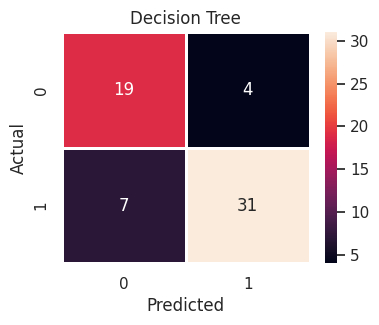

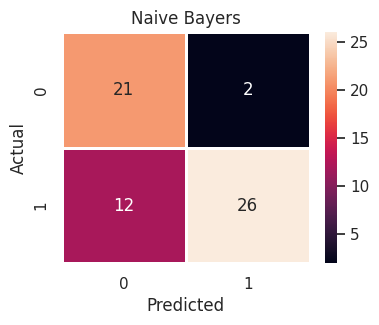

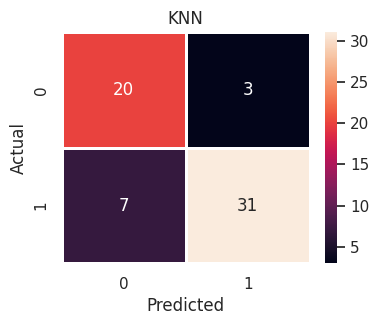

In [ ]:
show_matrix(df_RUN_PP1_results)

# **RUN_PP2**

***PP steps:***
- Remove 'fbs' 'sex', ' restecg' columns
- Normalization by MinMax Scaler

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP2_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP2_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,1.000,0.738,0.824,0.737,0.778
1,Naive Bayers,0.826,0.754,0.926,0.658,0.769
2,KNN,0.867,0.820,0.886,0.816,0.849


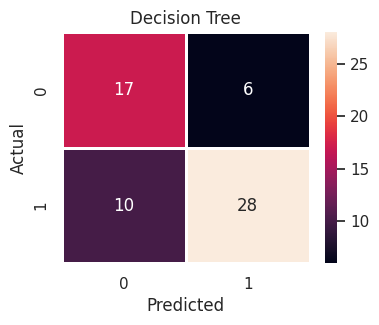

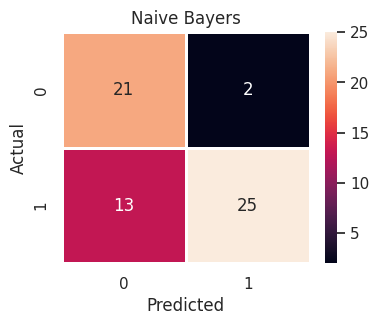

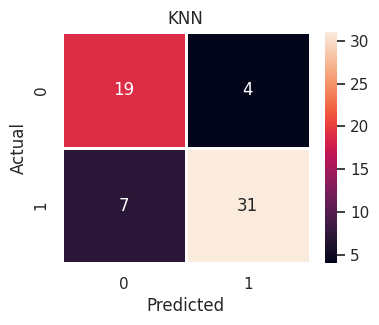

In [ ]:
show_matrix(df_RUN_PP2_results)

# **RUN_PP3**

***PP steps:***
- Remove 'fbs' 'sex', ' restecg' columns
- Normalization by MinMax Scaler
- Remove outliers

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP3_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP3_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,1.000,0.638,0.667,0.727,0.696
1,Naive Bayers,0.825,0.776,0.833,0.758,0.794
2,KNN,0.873,0.759,0.771,0.818,0.794


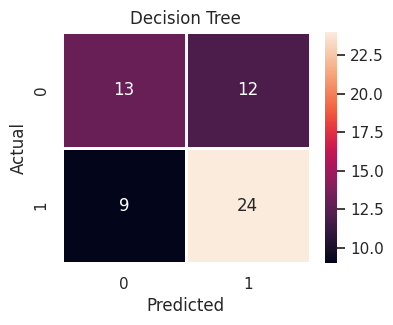

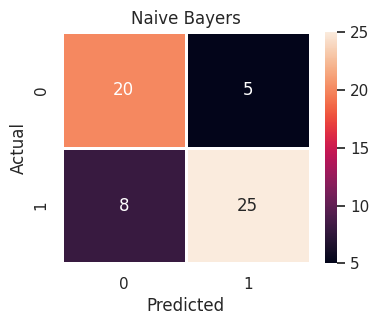

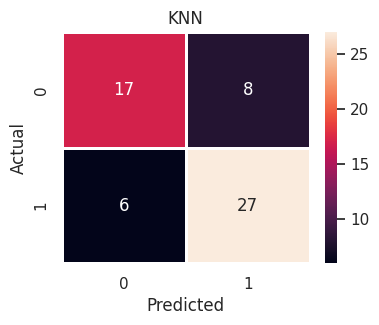

In [ ]:
show_matrix(df_RUN_PP3_results)

# **RUN_PP4**

***PP steps:***
- Remove 'fbs' 'sex', ' restecg' columns
- Normalization by MinMax Scaler
- Remove outliers

***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP4_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP4_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.908,0.707,0.767,0.697,0.730
1,Naive Bayers,0.825,0.776,0.833,0.758,0.794
2,KNN,0.851,0.759,0.744,0.879,0.806


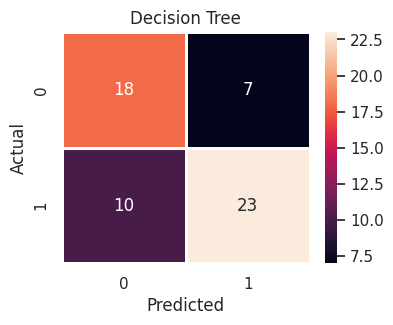

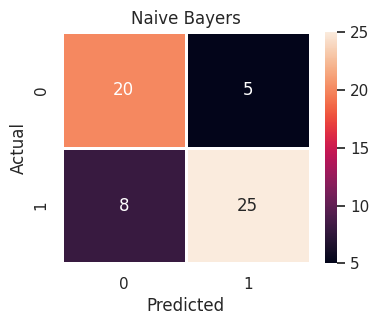

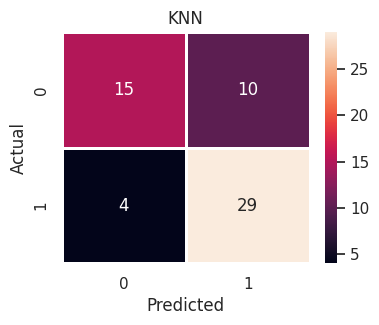

In [ ]:
show_matrix(df_RUN_PP4_results)

# **RUN_PP5**

***PP steps:***
- Remove 'fbs' 'sex', ' restecg' columns
- Normalization by MinMax Scaler
- Remove outliers
- Smoothing by bin boundaries (equal depth) on 'chol' 'bloodP' 'age' 'maxHR'
- One-hot encoding on 'thall'

***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP5_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP5_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.904,0.741,0.821,0.697,0.754
1,Naive Bayers,0.833,0.776,0.857,0.727,0.787
2,KNN,0.860,0.759,0.744,0.879,0.806


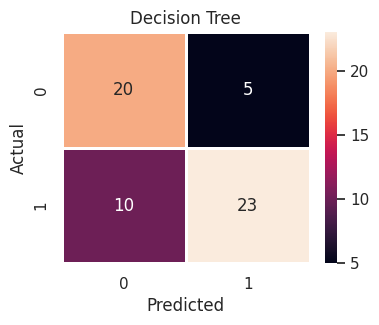

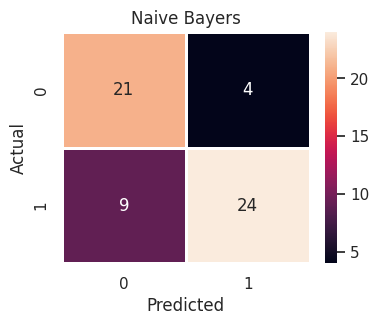

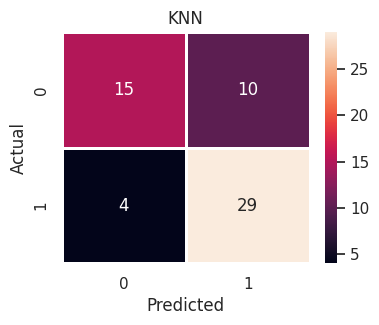

In [ ]:
show_matrix(df_RUN_PP5_results)

# **RUN_PP6**

***PP steps:***

- Remove 'fbs' columns
- Normalization by MinMax Scaler
- Smoothing by bin boundaries (equal depth) on 'chol' 'bloodP' 'age' 'maxHR'
- One-hot encoding on 'thall'






***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP6_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP6_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.900,0.705,0.833,0.658,0.735
1,Naive Bayers,0.822,0.803,0.964,0.711,0.818
2,KNN,0.838,0.918,0.971,0.895,0.932


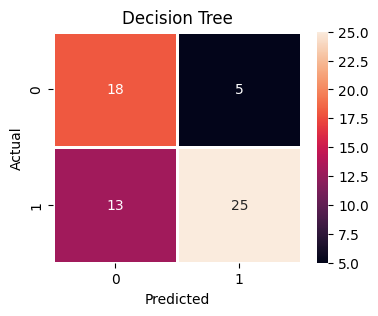

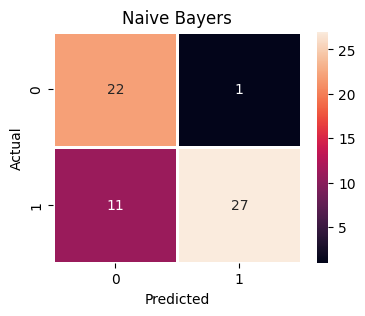

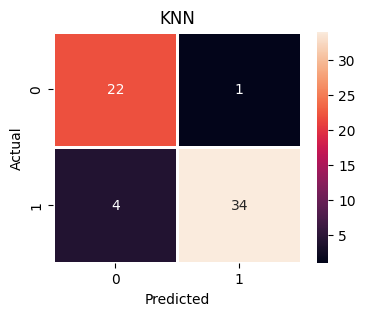

In [ ]:
show_matrix(df_RUN_PP6_results)

# **RUN_PP7**

***PP steps:***

- Remove 'fbs' columns
- Normalization by Standart Scaler
- Smoothing by bin means (equal width) on 'chol' 'bloodP' 'age' 'maxHR'
- One-hot encoding on 'thall'.





***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP7_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP7_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.900,0.705,0.857,0.632,0.727
1,Naive Bayers,0.834,0.803,1.000,0.684,0.813
2,KNN,0.834,0.885,0.919,0.895,0.907


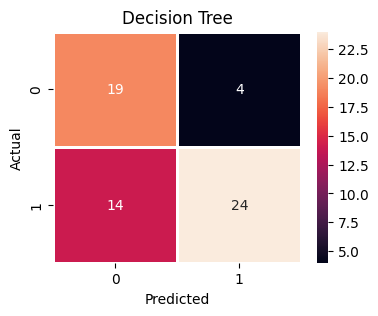

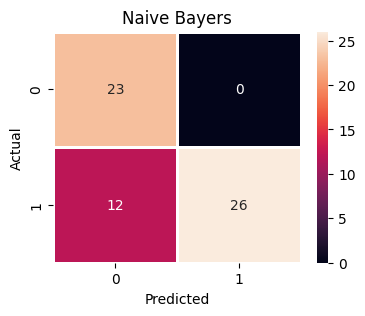

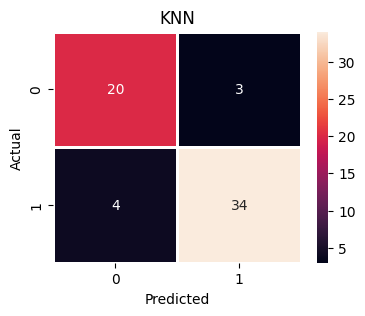

In [ ]:
show_matrix(df_RUN_PP7_results)

# **RUN_PP8(BEST_RESULT)**

***PP steps:***

- Remove 'fbs' column
- Normalization by Standart Scaler
- Smoothing by bin means (equal width) on 'chol' 'bloodP' 'age' 'maxHR'
- One-hot encoding on 'thall', 'slp', 'caa'




***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP8_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP8_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.917,0.721,0.862,0.658,0.746
1,Naive Bayers,0.830,0.836,0.938,0.789,0.857
2,KNN,0.838,0.951,0.949,0.974,0.961


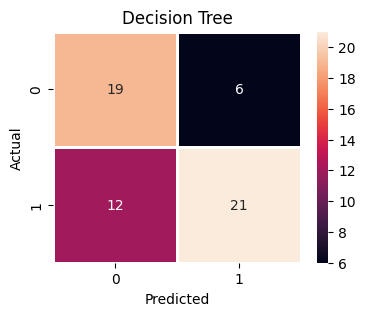

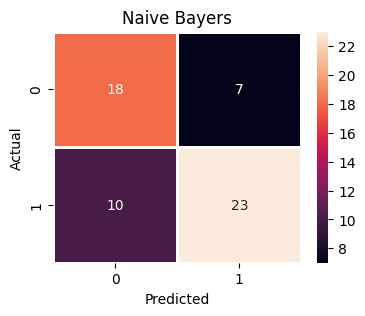

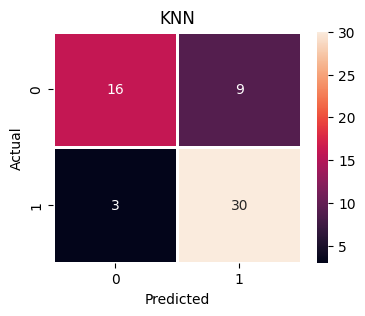

In [ ]:
show_matrix(df_RUN_PP8_results)

# **RUN_PP9**

***PP steps:***


- Remove 'fbs' column
- Normalization by Standart Scaler
- Smoothing by bin means (equal width) on 'chol' 'bloodP' 'age' 'maxHR'





***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP9_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP9_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.905,0.869,0.941,0.842,0.889
1,Naive Bayers,0.855,0.787,0.931,0.711,0.806
2,KNN,0.834,0.885,0.919,0.895,0.907


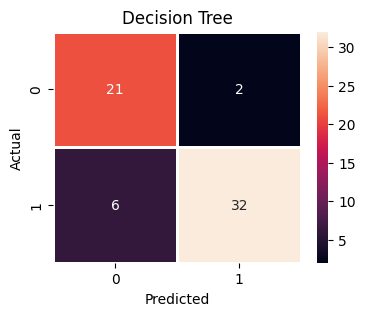

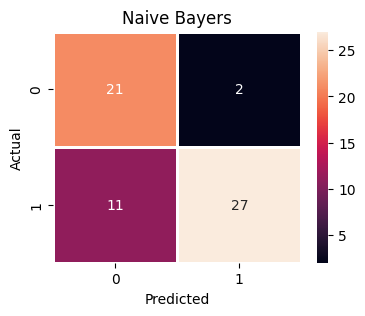

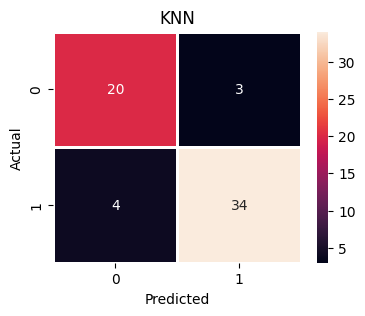

In [ ]:
show_matrix(df_RUN_PP9_results)

# **RUN_PP10**

***PP steps:***

- Remove 'fbs' column
- Normalization by Standart Scaler
- Smoothing by bin means (equal width) on 'chol' 'bloodP' 'age' 'maxHR'
- One-hot encoding on 'thall', slp, caa
- Remove columns thall slp caa



***Models config:***
- **DT** ▶ criterion= 'entropy', max_depth = 6, min_samples_split = 10,
 random_state=40 KNN - n_neighbors=11
- **KNN**  ▶  n_neighbors=11

In [ ]:
metrics = []

metrics.append(Decision_Tree())
metrics.append(Naive_Bayers())
metrics.append(KNN())


df_RUN_PP10_results = pd.DataFrame(metrics,columns=['Model','Accuracy_Train','Accuracy_Test','Precision','Recall','F-measure', 'matrix'])

df_RUN_PP10_results.drop('matrix', axis=1).round(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F-measure
0,Decision Tree,0.921,0.770,0.875,0.737,0.800
1,Naive Bayers,0.834,0.852,0.939,0.816,0.873
2,KNN,0.863,0.918,0.946,0.921,0.933


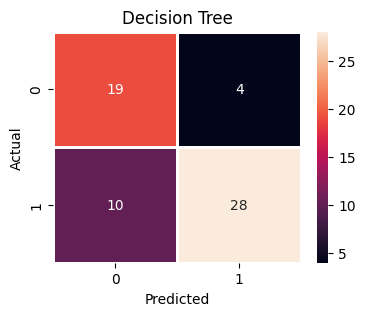

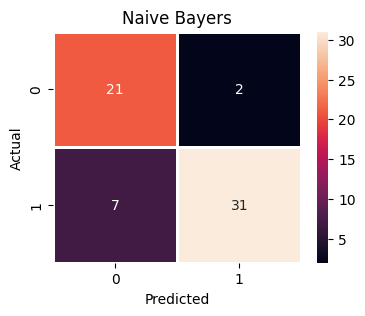

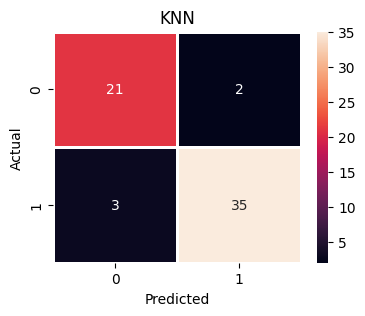

In [ ]:
show_matrix(df_RUN_PP10_results)